### Preliminary Exploratory Data Analysis# What makes a Champion?
## DSCI 100 Group 15 Project Proposal

Arimoto, Yuhei - 36561967 | 
Dufour-Nogueira, Emma Héloïse - 34570614 | 
Huang, Felix - 15914948 | 
Tan Palanca, Katrina Marie (Kim) - 98857568

### Introduction

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

### Data Analysis

#### Tidying

In [31]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

set.seed(1234)

#this library() function loads the tidymodels, repr, tidyverse, and GGally libraries into R
#the set.seed() function sets the seed for the project

In [32]:
data <- read_csv("https://raw.githubusercontent.com/kimtanpalanca/dsci_group_15/main/atp2017-2019.csv")
#the tennnis player data is referred to as the object "data" throughout this analysis

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [33]:
data <- data%>%
    select(winner_name,
           w_ace,
           w_df, 
           w_svpt, 
           w_SvGms, 
           w_1stIn, 
           w_1stWon, 
           loser_name)%>%
#the columns relevant to our analysis are selected using this select() function
    filter(!is.na(winner_name),
           !is.na(w_ace),
           !is.na(w_df),
           !is.na(w_svpt),
           !is.na(w_SvGms),
           !is.na(w_1stIn),
           !is.na(w_1stWon))
#the !is.na() argument in the filter() function eliminates NA values in the relevant columns

head(data, 5)

winner_name,w_ace,w_df,w_svpt,w_SvGms,w_1stIn,w_1stWon,loser_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Kei Nishikori,3,3,77,13,44,31,Daniil Medvedev
Daniil Medvedev,10,1,52,10,33,28,Jo Wilfried Tsonga
Kei Nishikori,2,2,47,8,33,26,Jeremy Chardy
Jo Wilfried Tsonga,12,2,68,11,43,34,Alex De Minaur
Daniil Medvedev,12,3,105,16,68,48,Milos Raonic


In [34]:
#the following code tidies the data

player_data <- data%>%
    select(winner_name, 
           loser_name)%>%
    filter(!is.na(winner_name), 
           !is.na(loser_name))
#this code creates a dataframe containing all of the players' names in the original data (both winners and losers)
#the frequency of repetition of these names is equivalent to the number of matches that each player partook in
#(e.g. player X appears twice, he took part in 2 matches)

player_data_column <- data.frame(all_players=unlist(player_data, use.names = FALSE))
#this code creates a single column containing all of the players names

winner_names <- player_data%>%
    group_by(winner_name)%>%
    summarize(n_wins = n())%>%
    distinct()
#this code creates a table containing only the winners names as well as the number of wins of each winning player

n_games_all <- player_data_column%>%
    group_by(all_players)%>%
    summarize(n_games = n())%>%
    subset(all_players %in% winner_names$winner_name)
#this code adds a column to player_data_column containing the number of games each player partook in
#it then extracts the rows which contain player names present in winner_names (i.e. restricts the data to only winners)

winner_data <- tibble(winner_name = winner_names$winner_name,
                      n_wins = winner_names$n_wins, 
                      n_games = n_games_all$n_games)%>%
    mutate(percentage_win = (n_wins/n_games)*100)
#this code creates a tibble containing the winners' names, their number of matches won, and the total number of matches they partook in
#the mutate() function then adds a column detailing the win ratios of each winner in relation to their total number of matches played in (win/total)

data <- data%>%
    group_by(winner_name)%>%
    summarize(number_of_wins = n(),
              avg_ace = mean(w_ace),
              avg_df = mean(w_df),
              avg_svpt = mean(w_svpt),
              avg_svgm = mean(w_SvGms),
              avg_first = mean(w_1stIn),
              avg_first_won = mean(w_1stWon))%>%
#removing repeats in data by averaging all the values over three years
    bind_cols(winner_data)%>%
#combining the relevant columns in winner_data with the data dataframe
    rename(winner_name = winner_name...1)%>%
    mutate(total_avg_svpt = avg_svpt + avg_svgm,
#summing service points and service games (both are points earned by serving)
           first_win_percentage_avg = (avg_first_won/avg_first)*100)%>%
#calculating the percentage of successful first serves
     filter(n_games > 50)%>%
#filtering for winners who play at least 50 games in order to eliminate outliers
    select(percentage_win,
           avg_ace, 
           avg_df, 
           total_avg_svpt, 
           first_win_percentage_avg)%>%
#selecting relevant variables
    mutate(avg_ace = round(avg_ace, 2),
           avg_df = round(avg_df, 2), 
           total_avg_svpt = round(total_avg_svpt, 2), 
           first_win_percentage_avg = round(first_win_percentage_avg, 2),
           percentage_win = round(percentage_win, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

New names:
* winner_name -> winner_name...1
* winner_name -> winner_name...9



#### Exploration and Visualization

In [35]:
data_split <- initial_split(data, prop = 0.75, strata = percentage_win)
data_train <- training(data_split)
data_test <- testing(data_split)

#randomly splits 75% of the data into the training and testing sets using
#percentage_win as the strata

In [36]:
train_summmary <- data_train%>%
    tibble(number_of_players = nrow(data_train),                                                   #total number of winners in the data
           avg_ace_n = mean(avg_ace),                                                              #average number of aces of each winner
           avg_df_n = mean(avg_df),                                                                #average number of double faults by each winner
           avg_total_avg_svpt = mean(total_avg_svpt),                                              #average total number of points earned by serving of each winner
           avg_first_win_percentage_avg = mean(first_win_percentage_avg),                          #average percentage of succesful first serves of each winner
           top_win_p = max(percentage_win),                                                        #highest win ratio in the data 
           bottom_win_p = min(percentage_win))%>%                                                  #lowest win ratio in the data
    select(number_of_players, 
           avg_ace_n, avg_df_n, 
           avg_total_avg_svpt, 
           avg_first_win_percentage_avg, 
           top_win_p, 
           bottom_win_p)%>%
#the select() function keeps relevant columns
    slice(1)%>%
    mutate(number_of_players = as.double(number_of_players), 
           avg_ace_n = round(avg_ace_n, 2),
           avg_df_n = round(avg_df_n, 2), 
           avg_total_avg_svpt = round(avg_total_avg_svpt, 2), 
           avg_first_win_percentage_avg = round(avg_first_win_percentage_avg, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

train_summmary

number_of_players,avg_ace_n,avg_df_n,avg_total_avg_svpt,avg_first_win_percentage_avg,top_win_p,bottom_win_p
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
80,7.44,2.78,93.74,76.28,88.24,29.31


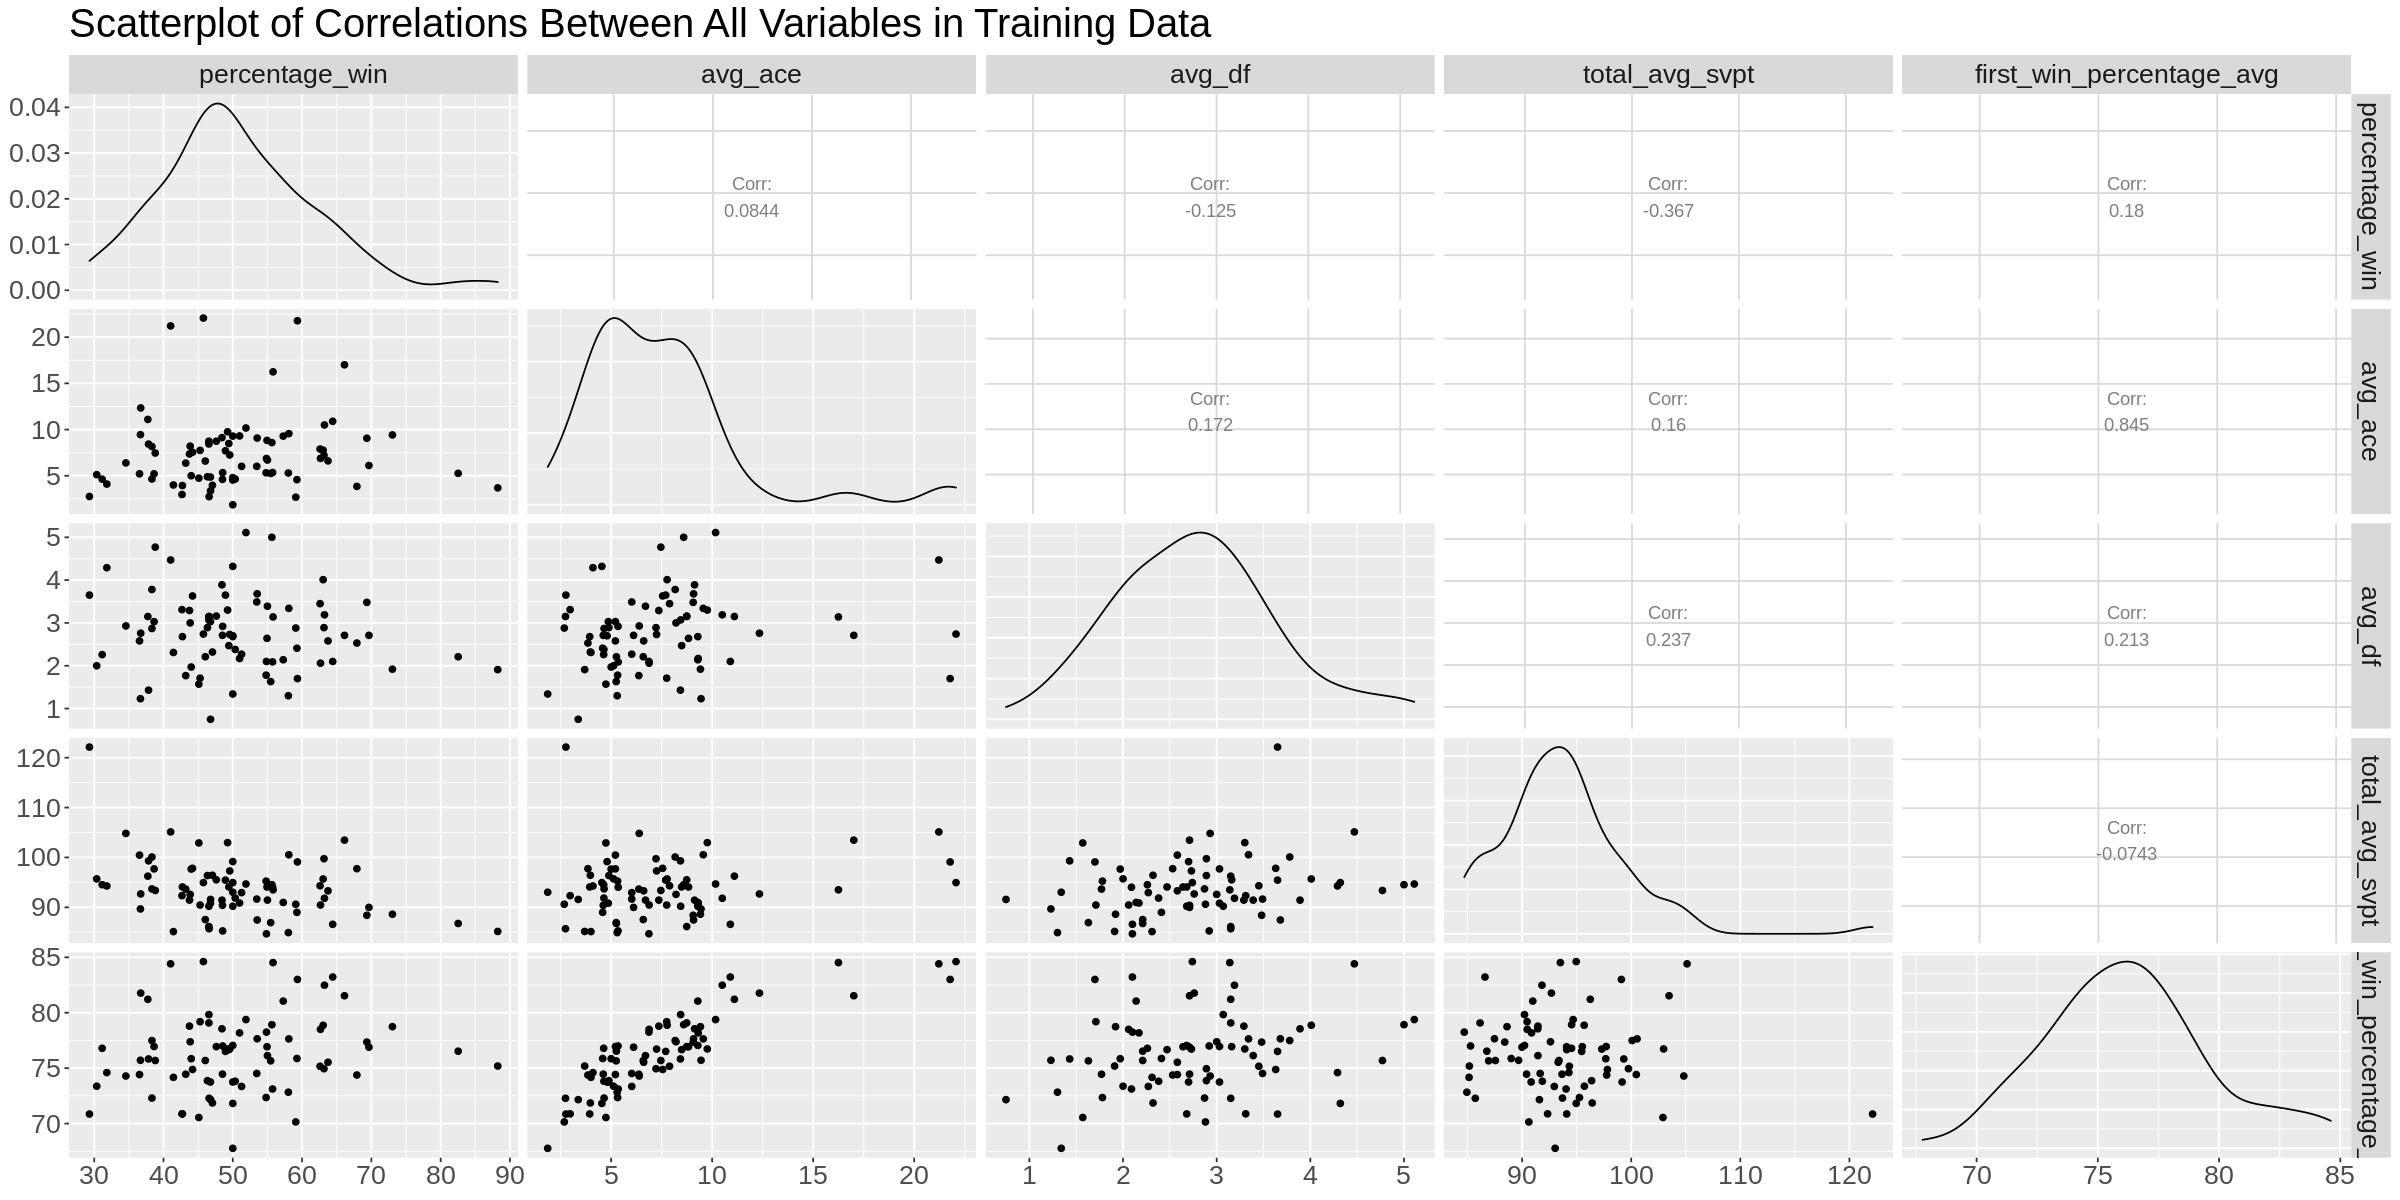

In [37]:
options(repr.plot.width = 20, repr.plot.height = 10)

relationships <- data_train %>%
    ggpairs(columns = 1:ncol(data_train), title = "Scatterplot of Correlations Between All Variables in Training Data", axisLabels = "show") +
#plotting the correlations between all variables against each other in data_train
    theme(text = element_text(size = 20))
    
relationships

#### Building a KNN Regression Classifier Model

In [38]:
recipe <- recipe(percentage_win ~ ., data = data_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#creating a recipe
#this involves sclaing and centering the predictors in the training data

In [39]:
folds <- vfold_cv(data_train, v = 10, strata = percentage_win)

#tuning the classifier using validation sets in the training data through 10 folds

In [40]:
model <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

#creating a predictive KNN regression model

In [41]:
rmspe <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(model) %>%
    tune_grid(
        resamples = folds, 
        grid = 100) %>%
    collect_metrics() %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1) 
rmspe

#calculating the RMSPE value (prediction accuracy) of the KNN model on the validation set

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,10.69662,10,0.5627384,Model14


In [42]:
kmin <- rmspe %>%
    pull(neighbors)
kmin

#extracting the value of the K-value associated with the smallest error (i.e. smallest RMSPE)

[1] 14

In [43]:
model_14 <- nearest_neighbor(
        weight_func = "rectangular", 
        neighbors = kmin) %>%
    set_engine("kknn") %>%
    set_mode("regression")

#creating a new KNN regression model using the best K-value (14)

In [44]:
workflow <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(model_14) %>%
    fit(data = data_train)

#gathering the multiple analysis steps in the workflow and fitting it using the selected K-value

In [45]:
rmse <- workflow %>%
    predict(data_train) %>%
    bind_cols(data_train) %>%
    metrics(truth = percentage_win, estimate = .pred) %>%
    filter(.metric == "rmse")
rmse

#calculating the RMSE value (prediction accuracy) of the new KNN model on the training set

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10.19109


In [46]:
summary <- workflow %>%
  predict(data_test) %>%
  bind_cols(data_test) %>%
  metrics(truth = percentage_win, estimate = .pred) %>%
  filter(.metric == "rmse")
summary

##calculating the RMSPE value (prediction accuracy) of the new KNN model on the testing set

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.584716


#### Visualizing the Results of the Analysis

In [47]:
predictions <- workflow %>%
  predict(data_train)%>%
  bind_cols(data_train)

#creating a tibble within which predicted value are shown alongside the true value

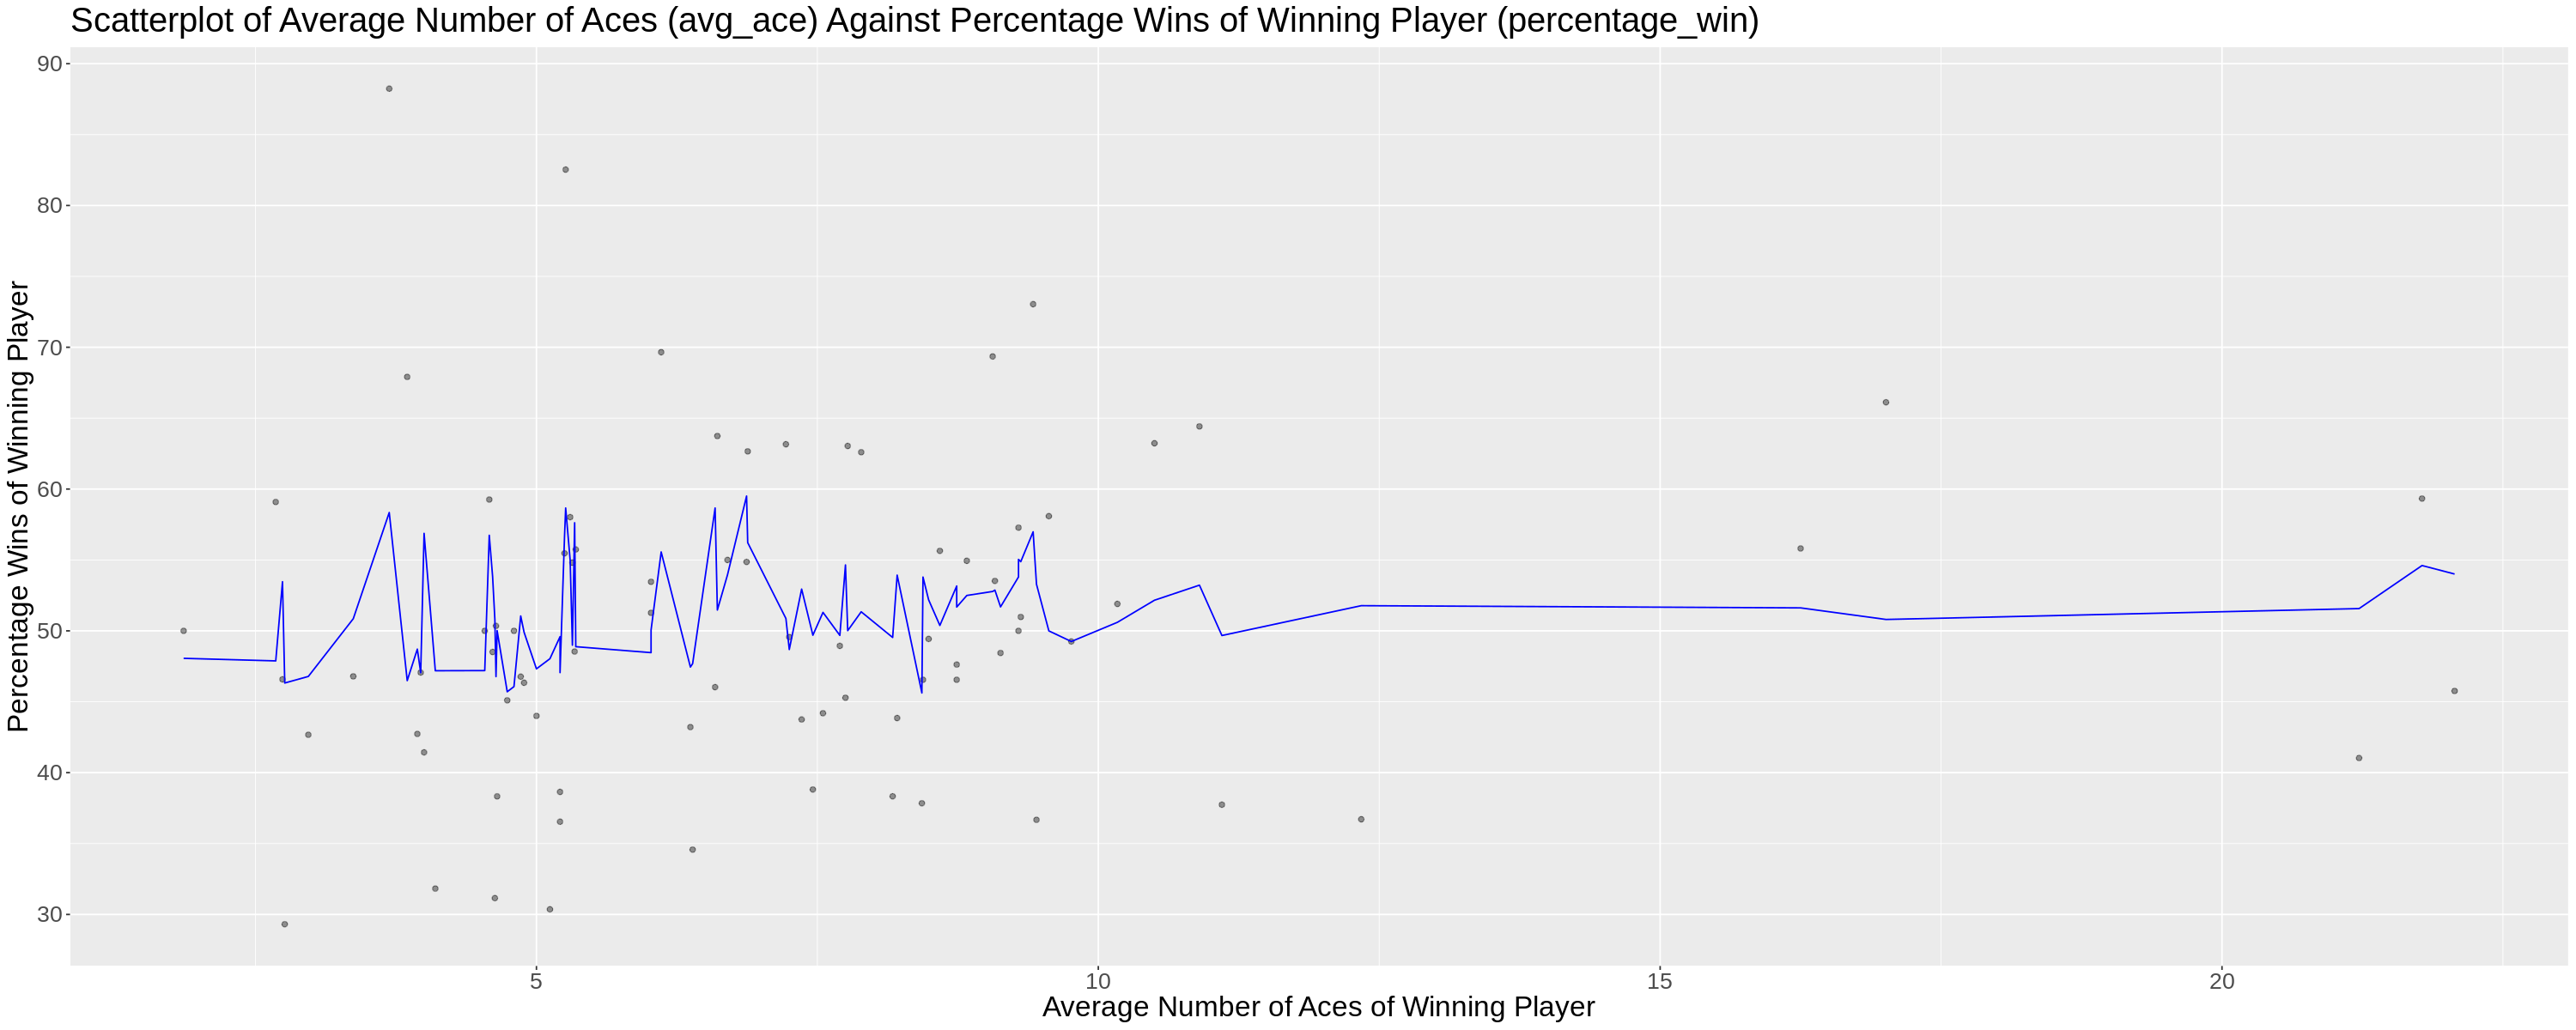

In [48]:
options(repr.plot.width = 25, repr.plot.height = 10)

ace_plot <- ggplot(predictions, aes(x = avg_ace, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Aces of Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = avg_ace, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Aces (avg_ace) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

ace_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

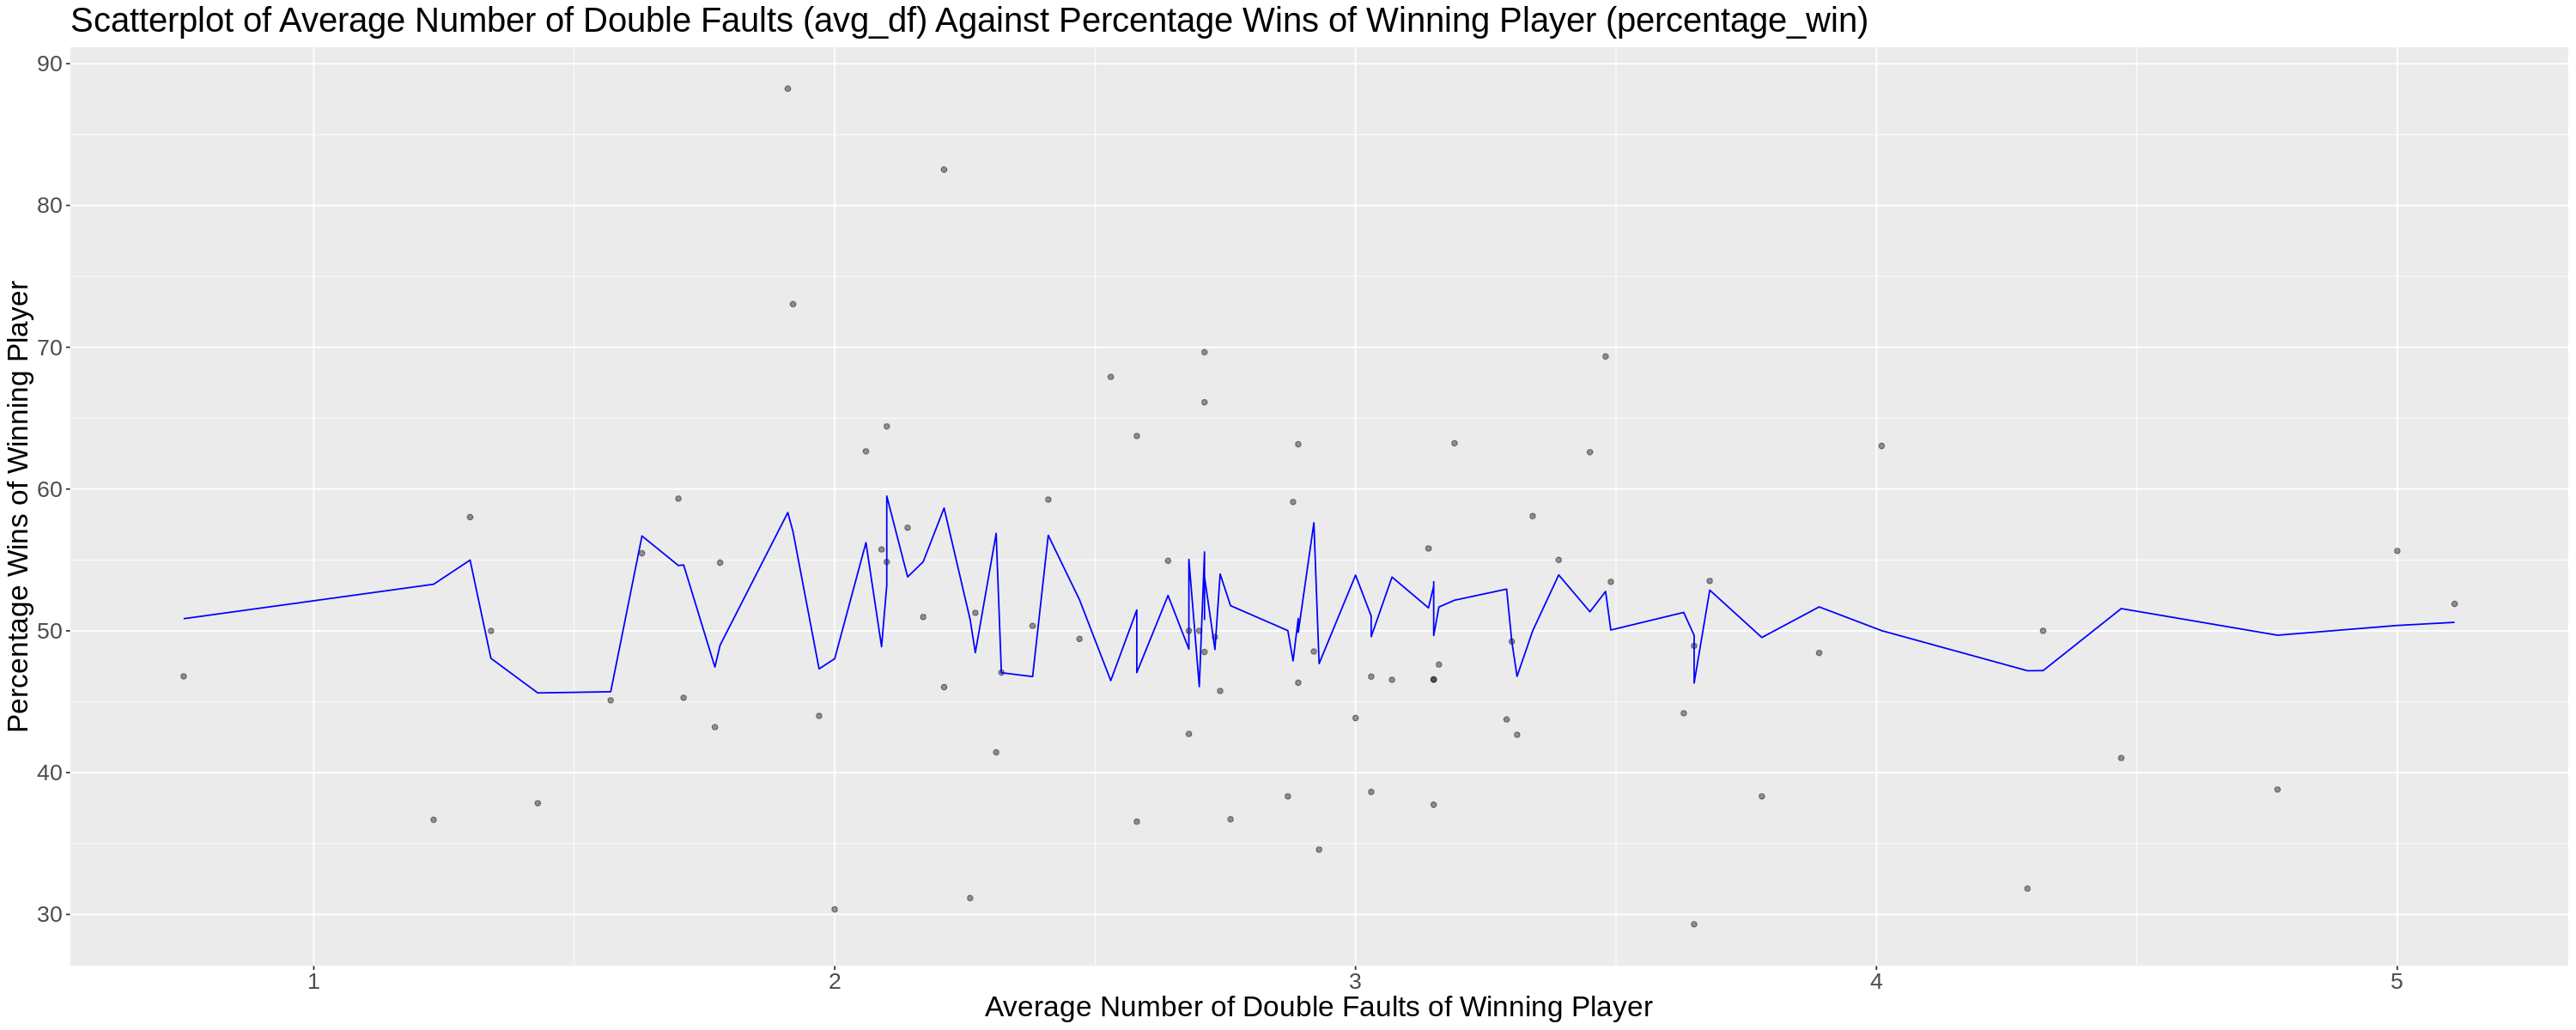

In [49]:
options(repr.plot.width = 25, repr.plot.height = 10)

df_plot <- ggplot(predictions, aes(x = avg_df, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Double Faults of Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = avg_df, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Double Faults (avg_df) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

df_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

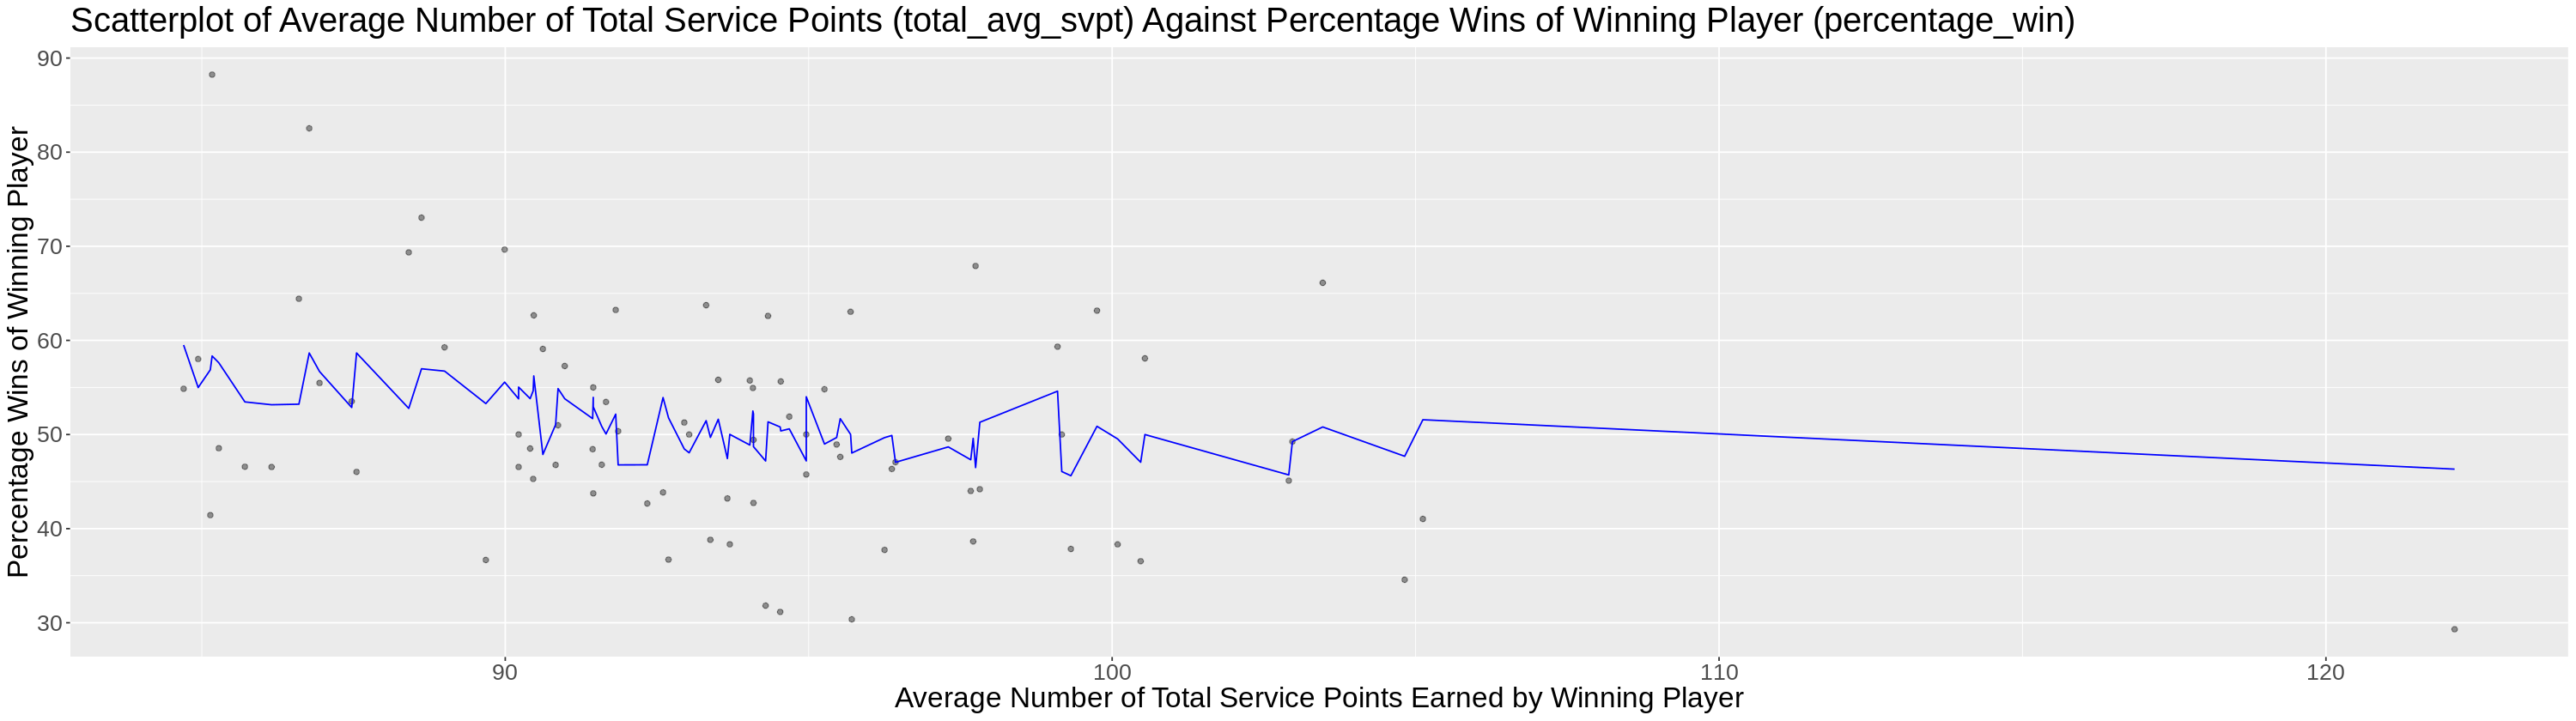

In [50]:
options(repr.plot.width = 25, repr.plot.height = 7)

svpt_plot <- ggplot(predictions, aes(x = total_avg_svpt, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Total Service Points Earned by Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = total_avg_svpt, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Total Service Points (total_avg_svpt) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

svpt_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

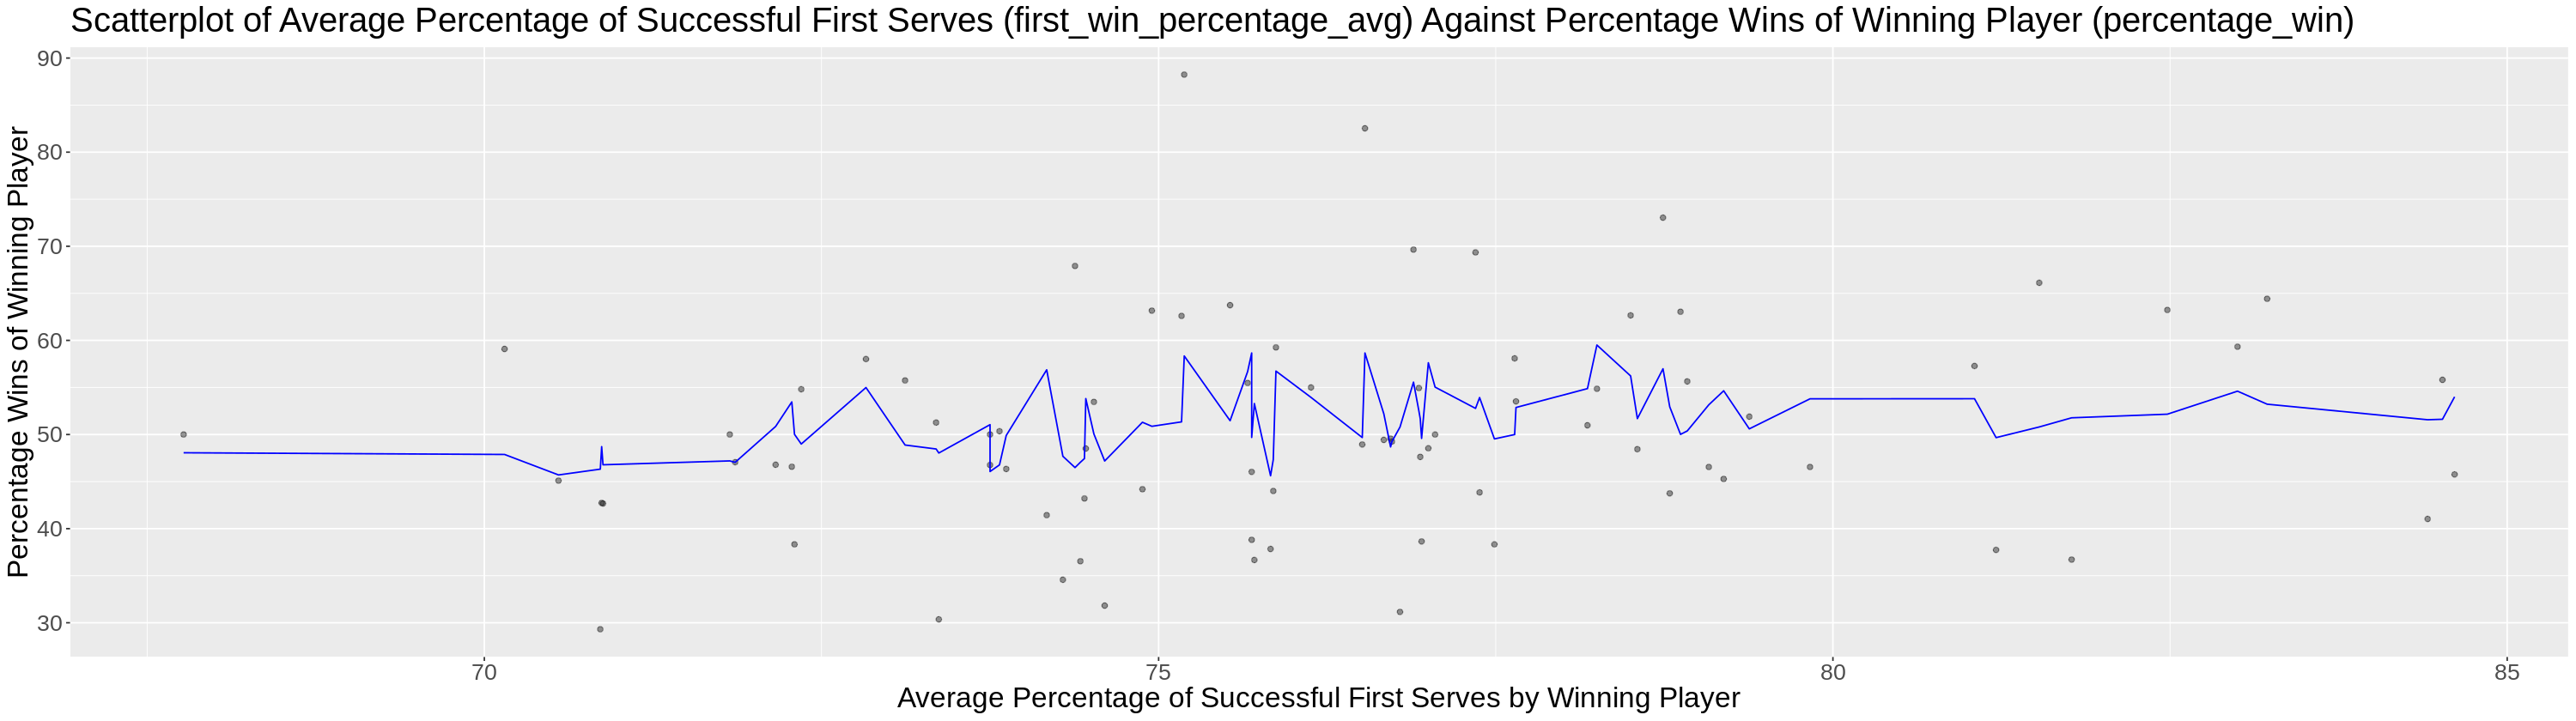

In [51]:
options(repr.plot.width = 25, repr.plot.height = 7)

win_plot <- ggplot(predictions, aes(x = first_win_percentage_avg, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Percentage of Successful First Serves by Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = first_win_percentage_avg, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Percentage of Successful First Serves (first_win_percentage_avg) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

win_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

### Discussion

### References